In [22]:
import math as math
import autograd as Agrad
#import autograd.numpy as np 
import numpy as np
import numpy.fft as fft
import scipy.optimize
import scipy.stats as st
from scipy.integrate import trapz
from scipy.integrate import simps
from photutils import find_peaks
from photutils import detect_threshold
# -- plotting --- 
import matplotlib as mpl 
import matplotlib.pyplot as plt
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False


np.random.seed(42)

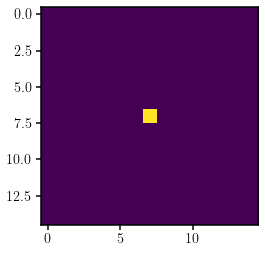

In [23]:
#create global definitions for the data

#create global definitions - this will become a main function later on
np.random.seed(42)
Ndata = 5;
n_grid = 15;
pix_1d = np.linspace(0., 1., n_grid) # pixel gridding
fdensity_true = float(Ndata)/float(n_grid**2); #number density of obj in 1d

#use very small psf and noise
sig_psf = 0.001 # psf width
sig_noise = 0.001 # noise level

#create our psf
mid = int(n_grid/2);
x,y = np.meshgrid(pix_1d,pix_1d);
psf = np.exp(-((y-pix_1d[mid])**2 + (x - pix_1d[mid])**2)/2/sig_psf**2); #keep in mind difference between x and y position and indices! Here, you are given indices, but meshgrid is in x-y coords
#fourier transform of psf
psf_k = fft.fft2(psf);
#display psf
plt.imshow(psf);

In [24]:
#create the mock data we will work on
#create coordinate grid
theta_grid = np.linspace(0., 1., n_grid) # gridding of theta (same as pixels)

#create true values - assign to grid
x_true = np.abs(np.random.rand(Ndata)) # location of sources
y_true = np.abs(np.random.rand(Ndata));
w_true = np.abs(np.random.rand(Ndata))*2 # with intensity betwen 1-2

#true grid needs to be set up with noise
w_true_grid = np.zeros((n_grid,n_grid))
for x,y, w in zip(x_true,y_true, w_true): 
    w_true_grid[np.argmin(np.abs(theta_grid - x)),np.argmin(np.abs(theta_grid - y))] = w
#now create the 'data' by convolving with psf and adding random noise
#by convolution thrm we conolve by inverse tranforming the multiplication of the fft of the data and fft of the psf

data = np.real(fft.ifft2(fft.fft2(w_true_grid)*psf_k)) + np.absolute(sig_noise* np.random.randn(n_grid,n_grid));

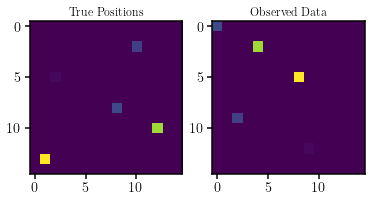

In [25]:
#display the true coordinates and observed data
fig, ax = plt.subplots(1,2)
ax[0].imshow(w_true_grid);
ax[0].set_title('True Positions')
ax[1].imshow(data);
ax[1].set_title('Observed Data')
plt.show();

Notice that the positions of the observed data do not match the true positions. This is due to the periodic boundary conditions of doing convolution, as we do not use padding to adjust.

In [26]:
#In order to minmize w.r.t. complex numbers we embed the complex nummbers into real space with twice the dimensions
#e.g. C -> 2R
#here are our helper functions for this
def real_to_complex(z):      # real vector of length 2n -> complex of length n
    return z[:len(z)//2] + 1j * z[len(z)//2:]

def complex_to_real(z):      # complex vector of length n -> real of length 2n
    return np.real(np.concatenate((np.real(z), np.imag(z))));

In [33]:
#now we define our loss function (basically log likelihood) and its gradient and hessian
#ws is the fourier coefficients embedded into the reals and flattened to a 1d array
def loss_fn(ws_k):
    ws_k = real_to_complex(ws_k); #2*reals -> complex
    ws_k = ws_k.reshape((n_grid,n_grid)); #reshape to 2d
    conv = np.real(fft.ifft2(ws_k*psf_k)); #convolution of ws with psf
    loss = 0.5 * np.sum((conv - data)**2) /sig_noise**2
    return loss;

def grad_loss(ws_k):
    ws_k = real_to_complex(ws_k); #2*reals -> complex
    ws_k = ws_k.reshape((n_grid,n_grid)); #reshape to 2d
    conv = np.real(fft.ifft2(ws_k*psf_k)); #convolution of ws with psf
    grad = fft.ifft2(conv - data)*psf_k/sig_noise**2 #gradient
    grad_real = complex_to_real(np.conj(grad)); #embed to 2R
    return grad_real.flatten(); #return 1d array

def hess_loss(ws_k):
    ws_k = real_to_complex(ws_k); #2*reals -> complex
    ws_k = ws_k.reshape((n_grid,n_grid)); #reshape to 2d
    
    diag = (psf_k/n_grid/sig_noise)**2;
    diag_real = complex_to_real(np.conj(diag));
    #this needs to be returned as a 2d array;
    hess = np.zeros((2*n_grid**2,2*n_grid**2)); #factor of two because of embeding from C -> 2R
    np.fill_diagonal(hess,diag_real);
    return hess;

In [34]:
#now we optimize wrt ws_k, the fourier coefficients

#create initial parameters
tt0 = np.zeros((n_grid,n_grid)) + 3; #begin with high uniform mass in each pixel
tt0_k = fft.fft2(tt0); #take fft
t_ini = complex_to_real(tt0_k.flatten()) #flatten to 1d for scipy and embed in 2R

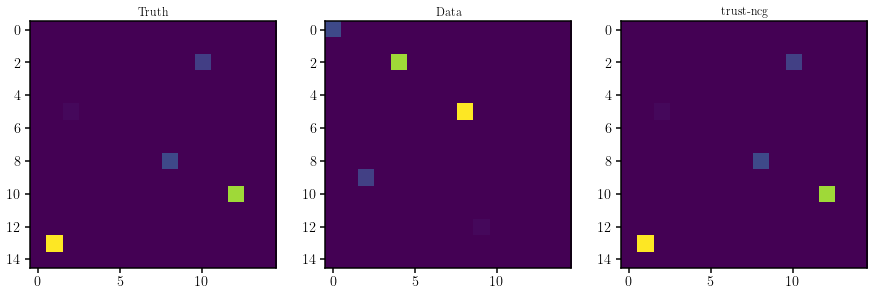

In [35]:
#optimize using scipy and our analytic gradients
res = scipy.optimize.minimize(lambda tt: loss_fn(tt),
    t_ini, # theta initial
    jac=grad_loss,
    hess = hess_loss,
    method='trust-ncg');

#remember this returns the fourier coefficients embeded in the reals
w_final_k = real_to_complex(res['x']);
w_final_k = w_final_k.reshape((n_grid,n_grid)); #reshape to 2d
w_final = np.real(fft.ifft2(w_final_k));
fig, ax = plt.subplots(1,3,figsize=(15,15))
ax[0].imshow(w_true_grid);
ax[0].set_title('Truth')
ax[1].imshow(data);
ax[1].set_title('Data')
ax[2].imshow(w_final);
ax[2].set_title('trust-ncg')
plt.show();